In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tqdm as tqdm

Files already downloaded and verified
Files already downloaded and verified


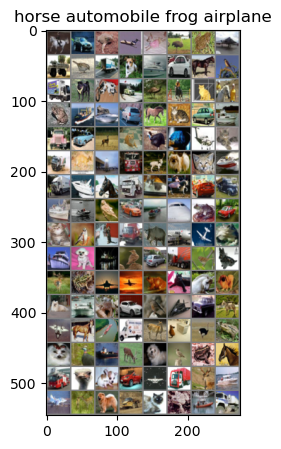

In [19]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 128, shuffle = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle = True)

images, labels = next(iter(trainloader))
classes = trainset.classes
plt.figure(figsize=(10,5))
plt.imshow(torchvision.utils.make_grid(images).permute(1,2,0) / 2 + 0.5)
plt.title(' '.join(classes[label] for label in labels[:4]));
plt.show()
test_losses = []

In [20]:
class CIFAR10_NN(nn.Module):
    def __init__(self, activation_name, with_vg, with_bn):
        super(CIFAR10_NN, self).__init__()
        self.activation = activation_name
        self.with_vg = with_vg
        self.with_bn = with_bn
        self.fcLayer1 = nn.Linear(32*32*3, 512)
        self.fcLayer2 = nn.Linear(512, 256)
        self.fcLayer3 = nn.Linear(256, 128)
        
        # Fixing vanishing gradient
        if ( with_vg and with_bn ):
            self.fcbnLayer1 = nn.BatchNorm1d(128)
            self.fcbnLayer2 = nn.BatchNorm1d(64)
            self.fcbnLayer3 = nn.BatchNorm1d(32)
            self.fcbnLayer4 = nn.BatchNorm1d(16)
        
        self.fcLayer4 = nn.Linear(128, 64)
            
        self.fcLayer5 = nn.Linear(64, 32)
            
            
        self.fcLayer6 = nn.Linear(32, 16)
        self.fcLayervg1 = nn.Linear(16, 16)
        # Introduce Vanishing gradient by adding more layers
        if ( with_vg ):
            self.fcLayervg2 = nn.Linear(16, 16)
            self.fcLayervg3 = nn.Linear(16, 16)
            self.fcLayervg4 = nn.Linear(16, 16)
            self.fcLayervg5 = nn.Linear(16, 16)
            self.fcLayervg6 = nn.Linear(16, 16)
            self.fcLayervg7 = nn.Linear(16, 16)
            self.fcLayervg8 = nn.Linear(16, 16)
            self.fcLayervg9 = nn.Linear(16, 16)
        self.fcLayervg10 = nn.Linear(16, 16)
        # Fixing vanishing gradient
        if ( with_vg and with_bn ):
            self.initialize_weights()
        self.fcoLayer = nn.Linear(16, 10)
        if activation_name == "sigmoid": 
            self.activation = nn.Sigmoid()
        elif activation_name == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Tanh()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fcLayer1(x))
        x = self.activation(self.fcLayer2(x))
        x = self.activation(self.fcLayer3(x))
        
        # Fixing vanishing gradient
        if ( self.with_vg and self.with_bn ):
            x = self.activation(self.fcbnLayer1(x))
        x = self.activation(self.fcLayer4(x))
        
        # Fixing vanishing gradient
        if ( self.with_vg and self.with_bn ):
            x = self.activation(self.fcbnLayer2(x))
        x = self.activation(self.fcLayer5(x))
        
        # Fixing vanishing gradient
        if ( self.with_vg and self.with_bn ):
            x = self.activation(self.fcbnLayer3(x))
        x = self.activation(self.fcLayer6(x))
        # Introduce Vanishing gradient by adding more layers
        if ( self.with_vg ):
            x = self.activation(self.fcLayervg1(x))
            x = self.activation(self.fcLayervg2(x))
            x = self.activation(self.fcLayervg3(x))
            x = self.activation(self.fcLayervg4(x))
            x = self.activation(self.fcLayervg5(x))
            x = self.activation(self.fcLayervg6(x))
            x = self.activation(self.fcLayervg7(x))
            x = self.activation(self.fcLayervg8(x))
            x = self.activation(self.fcLayervg9(x)) 
            x = self.activation(self.fcLayervg10(x))
        
        # Fixing vanishing gradient
        if ( self.with_vg and self.with_bn ):
            x = self.activation(self.fcbnLayer4(x))
        x = self.fcoLayer(x)
        return x
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if isinstance(self.activation, nn.ReLU):
                    nn.init.kaiming_normal_(m.weight)  # He initialization for relu activation
                else:
                    nn.init.xavier_normal_(m.weight)  # Xavier initialization for sigmoid and tanh activations
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

In [21]:
def train_and_test(activation, with_vg, with_bn):
    device = torch.device("cpu")
    model = CIFAR10_NN(activation, with_vg, with_bn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    epochs = 10
    train_losses = []
    test_losses = []
    gradient_logs = {}
    for epoch in range(epochs):
        running_loss = 0.0
        train_acc=0.0
        with tqdm.tqdm(total=len(trainloader)) as pbar:
            for batch_idx, (images, labels) in enumerate(trainloader):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss=criterion(outputs, labels)
                loss.backward()
                running_loss += loss.item()
                last_loss = loss.item()
                acc = torch.sum(torch.argmax(outputs, dim=1) == labels)
                train_acc += acc
                pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()), Accuracy='{0:.4f}'.format(float(train_acc.item()/(images.size(0)*(batch_idx+1)))))
                pbar.update(1)
                if batch_idx == len(trainloader) - 1:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {last_loss:.4f}")
                    check_gradients(model, gradient_logs, epoch)
                
                optimizer.step()
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        test_losses.append(test_loss / len(testloader))
        average_loss = running_loss / len(trainloader)
        train_losses.append(average_loss)
        print(f"{epoch + 1} / {epochs}, activation = {activation}, loss = {average_loss: .4f}")
    return train_losses, test_losses, gradient_logs

In [22]:
def check_gradients(model, gradient_logs, epoch):
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            if name not in gradient_logs:
                gradient_logs[name] = []
            if len(gradient_logs[name]) < epoch + 1:
                gradient_logs[name].append(grad_norm)
            else:
                gradient_logs[name][epoch] = grad_norm  # Ensure it logs per epoch

In [23]:
activation_fns = ["sigmoid", "tanh", "relu"]
with_vgs = [False, True] # Simulate vanishing gradient - true and false
with_bns = [False, True] # Fix simulated vanishing gradient by applying weight initialization and batch normalization - true and false
results = {}
for activation in activation_fns:
    for vg in with_vgs:
        for bn in with_bns:
            if not vg and bn: continue # Not necessary to do without vanishing gradient and with fix
            key = f"{activation}_vg{vg}_bn{bn}"
            results[key] = (train_and_test(activation, vg, bn))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.87it/s, Accuracy=0.2450, Loss=2.1460]


Epoch 1/10, Loss: 2.1460
1 / 10, activation = sigmoid, loss =  2.2116


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.79it/s, Accuracy=0.2811, Loss=2.0232]


Epoch 2/10, Loss: 2.0232
2 / 10, activation = sigmoid, loss =  2.1104


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 90.17it/s, Accuracy=0.3400, Loss=2.0383]


Epoch 3/10, Loss: 2.0383
3 / 10, activation = sigmoid, loss =  2.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 86.91it/s, Accuracy=0.3985, Loss=1.8214]


Epoch 4/10, Loss: 1.8214
4 / 10, activation = sigmoid, loss =  1.9559


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.32it/s, Accuracy=0.4246, Loss=1.8466]


Epoch 5/10, Loss: 1.8466
5 / 10, activation = sigmoid, loss =  1.8995


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.17it/s, Accuracy=0.4391, Loss=1.9022]


Epoch 6/10, Loss: 1.9022
6 / 10, activation = sigmoid, loss =  1.8593


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 85.51it/s, Accuracy=0.4560, Loss=1.8767]


Epoch 7/10, Loss: 1.8767
7 / 10, activation = sigmoid, loss =  1.8215


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.43it/s, Accuracy=0.4809, Loss=1.7998]


Epoch 8/10, Loss: 1.7998
8 / 10, activation = sigmoid, loss =  1.7793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.19it/s, Accuracy=0.5383, Loss=1.6238]


Epoch 9/10, Loss: 1.6238
9 / 10, activation = sigmoid, loss =  1.7118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 85.84it/s, Accuracy=0.5807, Loss=1.7092]


Epoch 10/10, Loss: 1.7092
10 / 10, activation = sigmoid, loss =  1.6658


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.27it/s, Accuracy=0.1601, Loss=2.3099]


Epoch 1/10, Loss: 2.3099
1 / 10, activation = sigmoid, loss =  2.3057


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.22it/s, Accuracy=0.1569, Loss=2.3036]


Epoch 2/10, Loss: 2.3036
2 / 10, activation = sigmoid, loss =  2.3034


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 81.84it/s, Accuracy=0.1595, Loss=2.3002]


Epoch 3/10, Loss: 2.3002
3 / 10, activation = sigmoid, loss =  2.3032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.74it/s, Accuracy=0.1571, Loss=2.3047]


Epoch 4/10, Loss: 2.3047
4 / 10, activation = sigmoid, loss =  2.3033


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.71it/s, Accuracy=0.1571, Loss=2.3060]


Epoch 5/10, Loss: 2.3060
5 / 10, activation = sigmoid, loss =  2.3032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.25it/s, Accuracy=0.1607, Loss=2.3059]


Epoch 6/10, Loss: 2.3059
6 / 10, activation = sigmoid, loss =  2.3032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.44it/s, Accuracy=0.1593, Loss=2.3062]


Epoch 7/10, Loss: 2.3062
7 / 10, activation = sigmoid, loss =  2.3031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.17it/s, Accuracy=0.1586, Loss=2.3014]


Epoch 8/10, Loss: 2.3014
8 / 10, activation = sigmoid, loss =  2.3031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.41it/s, Accuracy=0.1618, Loss=2.3048]


Epoch 9/10, Loss: 2.3048
9 / 10, activation = sigmoid, loss =  2.3031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.15it/s, Accuracy=0.1591, Loss=2.3018]


Epoch 10/10, Loss: 2.3018
10 / 10, activation = sigmoid, loss =  2.3032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.18it/s, Accuracy=0.2592, Loss=1.9887]


Epoch 1/10, Loss: 1.9887
1 / 10, activation = sigmoid, loss =  2.1637


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 78.18it/s, Accuracy=0.3310, Loss=2.1572]


Epoch 2/10, Loss: 2.1572
2 / 10, activation = sigmoid, loss =  1.9947


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 78.09it/s, Accuracy=0.3971, Loss=1.7530]


Epoch 3/10, Loss: 1.7530
3 / 10, activation = sigmoid, loss =  1.9255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 75.70it/s, Accuracy=0.4319, Loss=1.8611]


Epoch 4/10, Loss: 1.8611
4 / 10, activation = sigmoid, loss =  1.8777


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.63it/s, Accuracy=0.4609, Loss=1.8921]


Epoch 5/10, Loss: 1.8921
5 / 10, activation = sigmoid, loss =  1.8368


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 75.97it/s, Accuracy=0.4799, Loss=1.7887]


Epoch 6/10, Loss: 1.7887
6 / 10, activation = sigmoid, loss =  1.8069


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.33it/s, Accuracy=0.4989, Loss=1.7492]


Epoch 7/10, Loss: 1.7492
7 / 10, activation = sigmoid, loss =  1.7866


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.06it/s, Accuracy=0.5160, Loss=1.6805]


Epoch 8/10, Loss: 1.6805
8 / 10, activation = sigmoid, loss =  1.7689


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.84it/s, Accuracy=0.5272, Loss=1.7660]


Epoch 9/10, Loss: 1.7660
9 / 10, activation = sigmoid, loss =  1.7519


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 78.12it/s, Accuracy=0.5407, Loss=1.7132]


Epoch 10/10, Loss: 1.7132
10 / 10, activation = sigmoid, loss =  1.7346


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 86.08it/s, Accuracy=0.5207, Loss=1.8406]


Epoch 1/10, Loss: 1.8406
1 / 10, activation = tanh, loss =  1.9046


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.48it/s, Accuracy=0.6185, Loss=1.7891]


Epoch 2/10, Loss: 1.7891
2 / 10, activation = tanh, loss =  1.7393


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.65it/s, Accuracy=0.6763, Loss=1.5170]


Epoch 3/10, Loss: 1.5170
3 / 10, activation = tanh, loss =  1.6442


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.18it/s, Accuracy=0.7116, Loss=1.6335]


Epoch 4/10, Loss: 1.6335
4 / 10, activation = tanh, loss =  1.5784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.28it/s, Accuracy=0.7407, Loss=1.6556]


Epoch 5/10, Loss: 1.6556
5 / 10, activation = tanh, loss =  1.5269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 81.87it/s, Accuracy=0.7647, Loss=1.4378]


Epoch 6/10, Loss: 1.4378
6 / 10, activation = tanh, loss =  1.4881


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.12it/s, Accuracy=0.7872, Loss=1.3380]


Epoch 7/10, Loss: 1.3380
7 / 10, activation = tanh, loss =  1.4401


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.04it/s, Accuracy=0.8119, Loss=1.4161]


Epoch 8/10, Loss: 1.4161
8 / 10, activation = tanh, loss =  1.3985


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.50it/s, Accuracy=0.8324, Loss=1.3521]


Epoch 9/10, Loss: 1.3521
9 / 10, activation = tanh, loss =  1.3605


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 81.52it/s, Accuracy=0.8510, Loss=1.2874]


Epoch 10/10, Loss: 1.2874
10 / 10, activation = tanh, loss =  1.3272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.19it/s, Accuracy=0.2576, Loss=2.1421]


Epoch 1/10, Loss: 2.1421
1 / 10, activation = tanh, loss =  2.2098


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.05it/s, Accuracy=0.2435, Loss=2.2083]


Epoch 2/10, Loss: 2.2083
2 / 10, activation = tanh, loss =  2.2101


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.81it/s, Accuracy=0.2661, Loss=2.1065]


Epoch 3/10, Loss: 2.1065
3 / 10, activation = tanh, loss =  2.1528


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.61it/s, Accuracy=0.3385, Loss=2.0439]


Epoch 4/10, Loss: 2.0439
4 / 10, activation = tanh, loss =  2.0541


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 75.84it/s, Accuracy=0.4033, Loss=1.9285]


Epoch 5/10, Loss: 1.9285
5 / 10, activation = tanh, loss =  2.0036


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 78.14it/s, Accuracy=0.4516, Loss=2.0108]


Epoch 6/10, Loss: 2.0108
6 / 10, activation = tanh, loss =  1.9540


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.43it/s, Accuracy=0.4652, Loss=1.8165]


Epoch 7/10, Loss: 1.8165
7 / 10, activation = tanh, loss =  1.9339


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.68it/s, Accuracy=0.4731, Loss=1.9437]


Epoch 8/10, Loss: 1.9437
8 / 10, activation = tanh, loss =  1.9233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.72it/s, Accuracy=0.4605, Loss=1.9303]


Epoch 9/10, Loss: 1.9303
9 / 10, activation = tanh, loss =  1.9201


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.25it/s, Accuracy=0.4831, Loss=1.9379]


Epoch 10/10, Loss: 1.9379
10 / 10, activation = tanh, loss =  1.9037


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.19it/s, Accuracy=0.4813, Loss=1.7808]


Epoch 1/10, Loss: 1.7808
1 / 10, activation = tanh, loss =  1.9434


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.35it/s, Accuracy=0.5867, Loss=1.8010]


Epoch 2/10, Loss: 1.8010
2 / 10, activation = tanh, loss =  1.7891


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.42it/s, Accuracy=0.6254, Loss=1.7515]


Epoch 3/10, Loss: 1.7515
3 / 10, activation = tanh, loss =  1.7205


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.21it/s, Accuracy=0.6531, Loss=1.4945]


Epoch 4/10, Loss: 1.4945
4 / 10, activation = tanh, loss =  1.6741


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.35it/s, Accuracy=0.6803, Loss=1.6903]


Epoch 5/10, Loss: 1.6903
5 / 10, activation = tanh, loss =  1.6393


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 75.69it/s, Accuracy=0.6932, Loss=1.6283]


Epoch 6/10, Loss: 1.6283
6 / 10, activation = tanh, loss =  1.6024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.11it/s, Accuracy=0.7088, Loss=1.7277]


Epoch 7/10, Loss: 1.7277
7 / 10, activation = tanh, loss =  1.5780


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.19it/s, Accuracy=0.7224, Loss=1.4616]


Epoch 8/10, Loss: 1.4616
8 / 10, activation = tanh, loss =  1.5488


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 75.05it/s, Accuracy=0.7397, Loss=1.4798]


Epoch 9/10, Loss: 1.4798
9 / 10, activation = tanh, loss =  1.5250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.36it/s, Accuracy=0.7502, Loss=1.6480]


Epoch 10/10, Loss: 1.6480
10 / 10, activation = tanh, loss =  1.5049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.68it/s, Accuracy=0.5638, Loss=1.5813]


Epoch 1/10, Loss: 1.5813
1 / 10, activation = relu, loss =  1.7795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 91.99it/s, Accuracy=0.7338, Loss=1.4486]


Epoch 2/10, Loss: 1.4486
2 / 10, activation = relu, loss =  1.5254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 89.13it/s, Accuracy=0.8074, Loss=1.3623]


Epoch 3/10, Loss: 1.3623
3 / 10, activation = relu, loss =  1.4004


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.96it/s, Accuracy=0.8652, Loss=1.2932]


Epoch 4/10, Loss: 1.2932
4 / 10, activation = relu, loss =  1.3027


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.26it/s, Accuracy=0.9151, Loss=1.4169]


Epoch 5/10, Loss: 1.4169
5 / 10, activation = relu, loss =  1.2180


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 91.28it/s, Accuracy=0.9572, Loss=1.1411]


Epoch 6/10, Loss: 1.1411
6 / 10, activation = relu, loss =  1.1397


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 88.89it/s, Accuracy=0.9946, Loss=1.1092]


Epoch 7/10, Loss: 1.1092
7 / 10, activation = relu, loss =  1.0672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 86.39it/s, Accuracy=1.0345, Loss=0.9705]


Epoch 8/10, Loss: 0.9705
8 / 10, activation = relu, loss =  0.9992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 90.69it/s, Accuracy=1.0697, Loss=1.1254]


Epoch 9/10, Loss: 1.1254
9 / 10, activation = relu, loss =  0.9326


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 91.89it/s, Accuracy=1.1099, Loss=0.9687]


Epoch 10/10, Loss: 0.9687
10 / 10, activation = relu, loss =  0.8630


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.96it/s, Accuracy=0.2820, Loss=2.0501]


Epoch 1/10, Loss: 2.0501
1 / 10, activation = relu, loss =  2.1039


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 81.88it/s, Accuracy=0.3386, Loss=1.7898]


Epoch 2/10, Loss: 1.7898
2 / 10, activation = relu, loss =  1.9568


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.81it/s, Accuracy=0.4144, Loss=1.7888]


Epoch 3/10, Loss: 1.7888
3 / 10, activation = relu, loss =  1.8946


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 81.62it/s, Accuracy=0.4613, Loss=1.9085]


Epoch 4/10, Loss: 1.9085
4 / 10, activation = relu, loss =  1.8417


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 81.39it/s, Accuracy=0.4850, Loss=2.0775]


Epoch 5/10, Loss: 2.0775
5 / 10, activation = relu, loss =  1.8130


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.93it/s, Accuracy=0.4961, Loss=1.9501]


Epoch 6/10, Loss: 1.9501
6 / 10, activation = relu, loss =  1.8137


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.02it/s, Accuracy=0.5030, Loss=1.7450]


Epoch 7/10, Loss: 1.7450
7 / 10, activation = relu, loss =  1.8139


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.50it/s, Accuracy=0.5050, Loss=1.9107]


Epoch 8/10, Loss: 1.9107
8 / 10, activation = relu, loss =  1.8268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.02it/s, Accuracy=0.4727, Loss=1.8225]


Epoch 9/10, Loss: 1.8225
9 / 10, activation = relu, loss =  1.9042


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.44it/s, Accuracy=0.4539, Loss=1.7216]


Epoch 10/10, Loss: 1.7216
10 / 10, activation = relu, loss =  1.8811


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.64it/s, Accuracy=0.2707, Loss=2.0692]


Epoch 1/10, Loss: 2.0692
1 / 10, activation = relu, loss =  2.2089


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.41it/s, Accuracy=0.3226, Loss=1.9433]


Epoch 2/10, Loss: 1.9433
2 / 10, activation = relu, loss =  2.0640


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.84it/s, Accuracy=0.3441, Loss=1.9769]


Epoch 3/10, Loss: 1.9769
3 / 10, activation = relu, loss =  1.9547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.32it/s, Accuracy=0.4642, Loss=1.7222]


Epoch 4/10, Loss: 1.7222
4 / 10, activation = relu, loss =  1.8356


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.72it/s, Accuracy=0.5287, Loss=1.6074]


Epoch 5/10, Loss: 1.6074
5 / 10, activation = relu, loss =  1.7767


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.53it/s, Accuracy=0.5784, Loss=1.7259]


Epoch 6/10, Loss: 1.7259
6 / 10, activation = relu, loss =  1.6897


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.98it/s, Accuracy=0.6178, Loss=1.4952]


Epoch 7/10, Loss: 1.4952
7 / 10, activation = relu, loss =  1.6334


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 72.79it/s, Accuracy=0.6552, Loss=1.8834]


Epoch 8/10, Loss: 1.8834
8 / 10, activation = relu, loss =  1.5739


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 73.84it/s, Accuracy=0.6901, Loss=1.5431]


Epoch 9/10, Loss: 1.5431
9 / 10, activation = relu, loss =  1.5320


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.16it/s, Accuracy=0.7285, Loss=1.4166]


Epoch 10/10, Loss: 1.4166
10 / 10, activation = relu, loss =  1.4811


[2.211614787426141, 2.110412343078867, 2.0270684667865333, 1.955927451248364, 1.8994774044017353, 1.8592515939946674, 1.821462876351593, 1.779330738974959, 1.7118120355069484, 1.6657880032458878] [2.136161568798596, 2.0678945779800415, 1.9885405452945564, 1.932136932505837, 1.889709213111974, 1.8568658451490765, 1.846294117879264, 1.788120790372921, 1.7664292779149888, 1.7386887858185587]


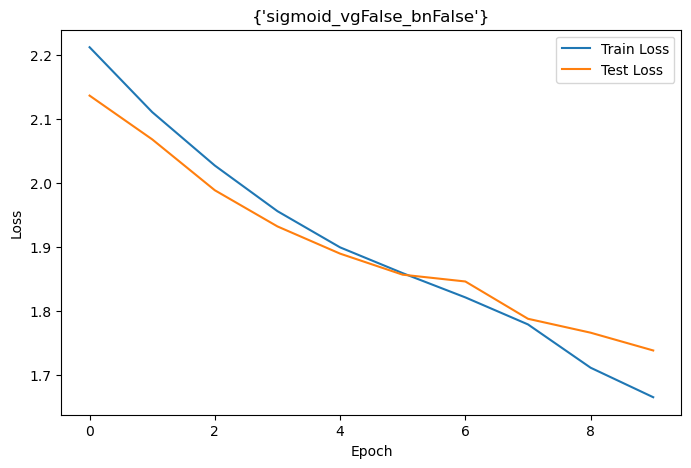

[2.3057416857356, 2.303433532909969, 2.3031604588793977, 2.303258686114455, 2.3031916545175224, 2.3031934618645007, 2.3031433817675655, 2.303145650707547, 2.3030993261605577, 2.3032433236651406] [2.3033888490894174, 2.3029383768009235, 2.303014670746236, 2.303248846078221, 2.3027241743063627, 2.303073001813285, 2.3030066641071176, 2.302846999108037, 2.302704177325285, 2.30262631404249]


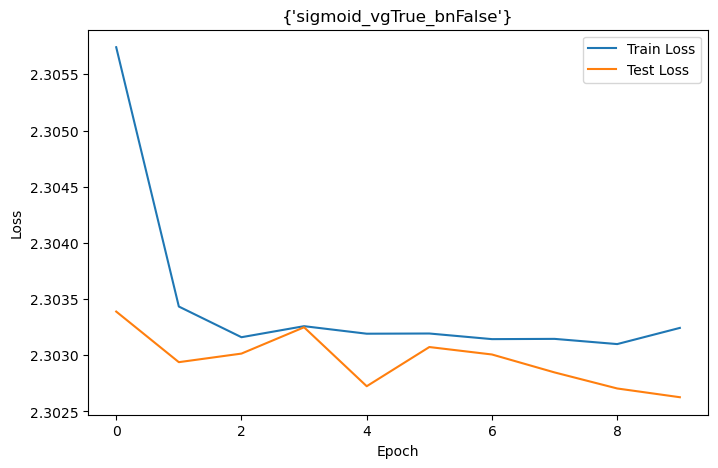

[2.1636826409708205, 1.9946918112542622, 1.925509099765202, 1.8776797495229776, 1.8367666414631603, 1.8069450257684263, 1.7866303820134428, 1.7689047634144268, 1.7519086007876774, 1.7346467575453737] [2.0353059406521954, 1.9513985401467433, 1.9001613055603415, 1.8916378504113307, 1.8546001292482208, 1.8440266983418525, 1.8294622943371157, 1.8202493356753, 1.835479822339891, 1.8030028479008735]


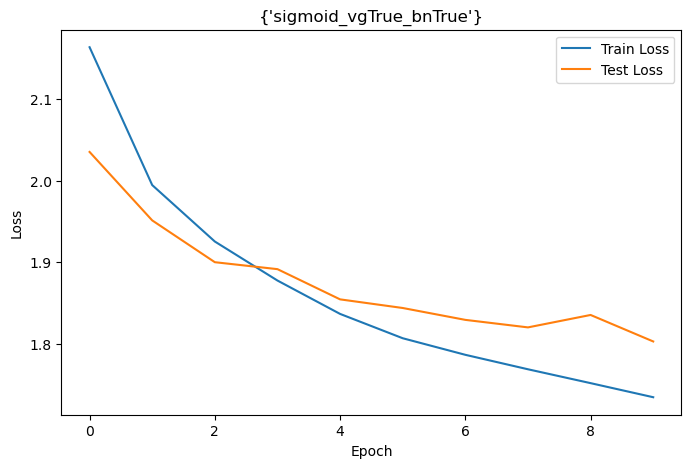

[1.9045799873064242, 1.7392723776800247, 1.6441606517947849, 1.5784172133716476, 1.5268648478686047, 1.488112974654683, 1.440079728355798, 1.3984859123864137, 1.360456872474202, 1.32715721691356] [1.8029205452037762, 1.7093922925900809, 1.6491081005410304, 1.588019609451294, 1.5852097137064873, 1.5793877281720126, 1.5395757955840872, 1.5299892712242995, 1.5263876613182357, 1.5234295507020588]


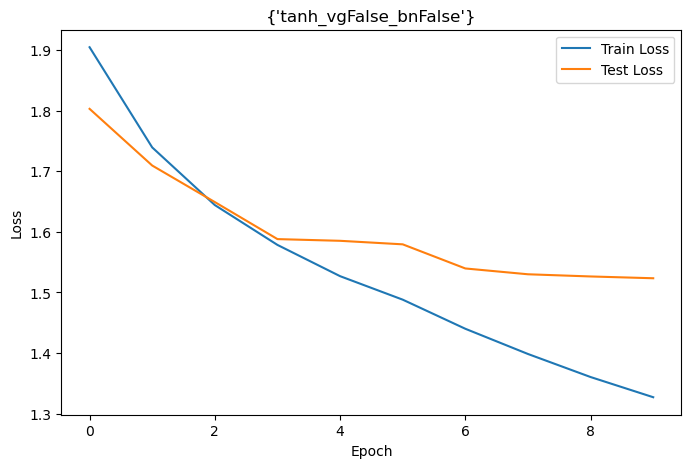

[2.209842810545431, 2.210118022721137, 2.152775545864154, 2.0541310404877526, 2.0036214364459144, 1.954005629815104, 1.9338958836577433, 1.9233112874848153, 1.9201374861895275, 1.9037334330551459] [2.1952406454689894, 2.1465271183207064, 2.086630472654029, 2.028605012954036, 1.9724395893797089, 1.9490660730796525, 1.9110299394100527, 1.9143179881421826, 1.906435918204392, 1.9317028507401672]


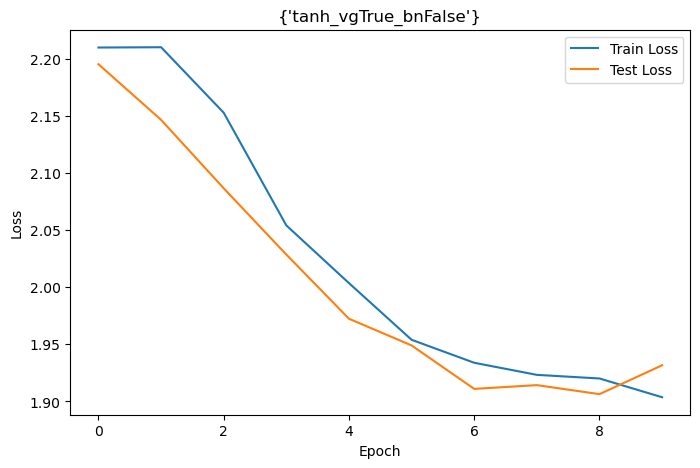

[1.9433834699108778, 1.7891070818352273, 1.720542703443171, 1.6740696177153331, 1.6392677476643907, 1.6023736396409056, 1.5779870242413963, 1.5487972369889165, 1.5250194036137417, 1.5049003841322097] [1.8312847765186164, 1.7439612044563777, 1.6955767447435404, 1.690929945511154, 1.6610908040517494, 1.6382789174212684, 1.6271590899817552, 1.6193691220464586, 1.6083569753019116, 1.6037878220594382]


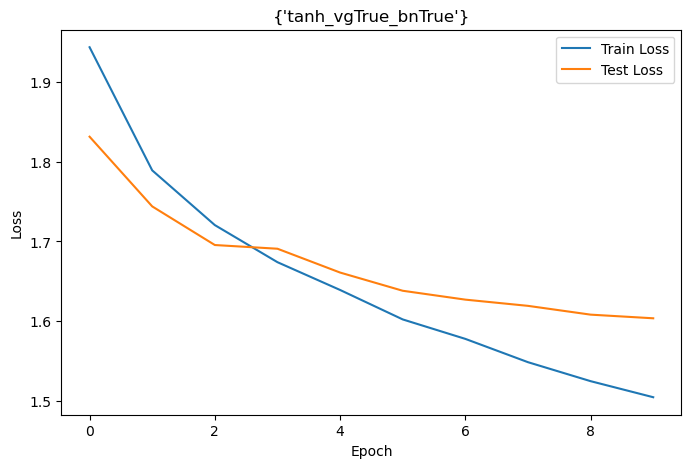

[1.7794886861006012, 1.5254053673171022, 1.400365334947396, 1.3026530803621883, 1.2179641709913074, 1.1397257909140623, 1.0672446213414908, 0.9992031391014529, 0.9325950442982451, 0.8629718107335708] [1.6249742568293704, 1.4982830919796908, 1.3946409829055206, 1.3975269975541513, 1.3443064101134674, 1.3501777060424225, 1.3266708549064925, 1.3560623896272876, 1.3768778488605837, 1.405278919618341]


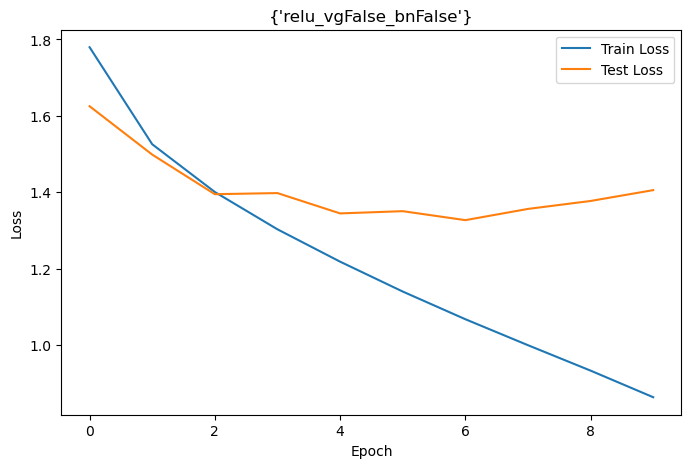

[2.103876415116098, 1.9567723786434554, 1.8946416106675288, 1.841701496897451, 1.812991017575764, 1.8136887623525946, 1.8139129520377235, 1.826846695617032, 1.904170780230666, 1.8811098370710602] [1.9740593131584456, 1.9306054130385193, 1.8791306682779818, 1.8537265575384791, 1.9130954772611208, 1.8179644663122636, 1.8217178869851027, 1.879273088672493, 1.8521932650216018, 1.868521408189701]


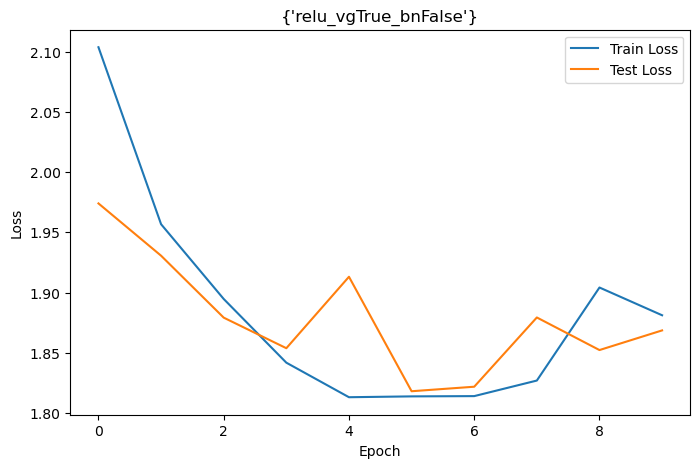

[2.2088528764827173, 2.063994450642325, 1.9546593214239916, 1.8355603513815213, 1.7767361000065913, 1.6896981095414028, 1.6333502528002806, 1.573898218781747, 1.531950021948656, 1.4810565993609026] [2.136398909967157, 2.028528937810584, 1.9001051715657682, 1.7932792524748211, 1.7104245620437815, 1.6893608283392991, 1.6565975041329106, 1.6668722222122965, 1.6176980794230593, 1.6358319038077245]


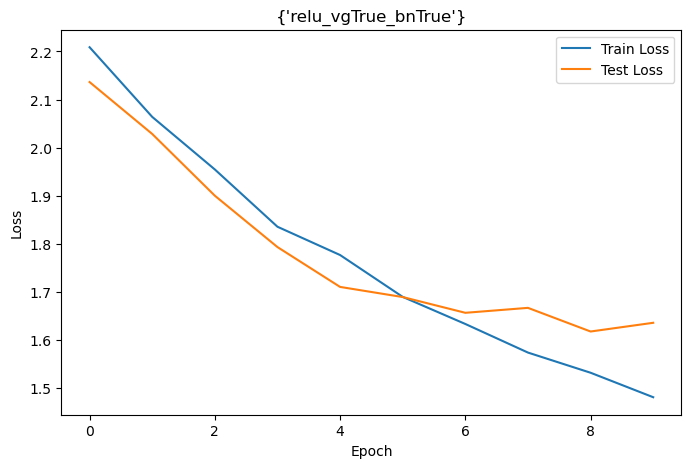

In [24]:
# Plotting results for train and test loss
for name, result in results.items():
    print(result[0], result[1])
    plt.figure(figsize=(8, 5))
    plt.plot(result[0], label = 'Train Loss')
    plt.plot(result[1], label = 'Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title({name})
    plt.legend()
    plt.show()

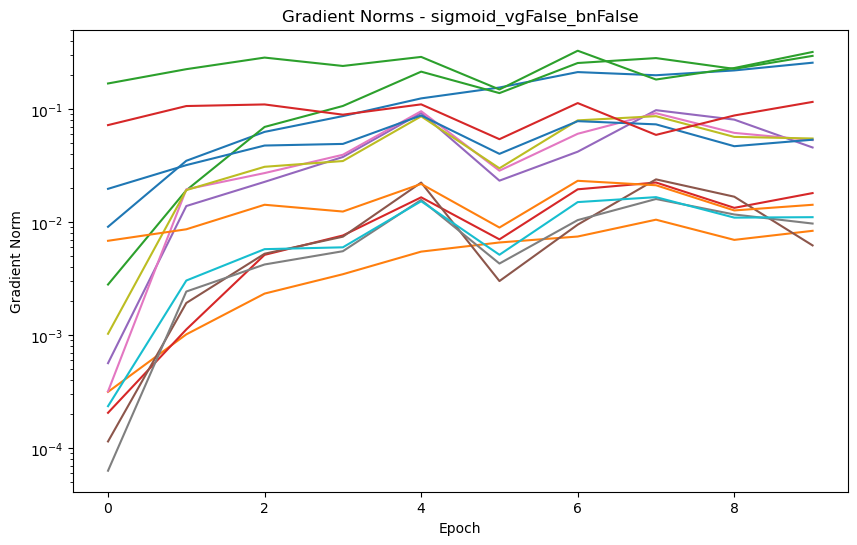

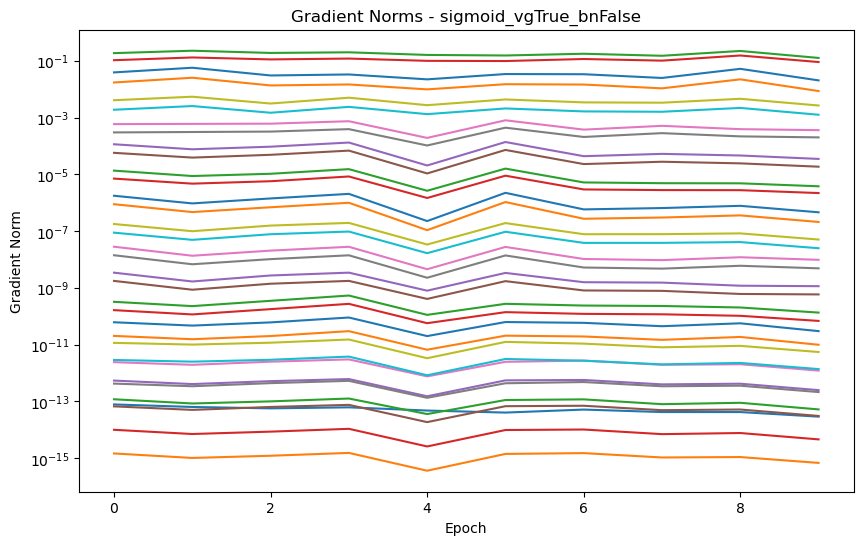

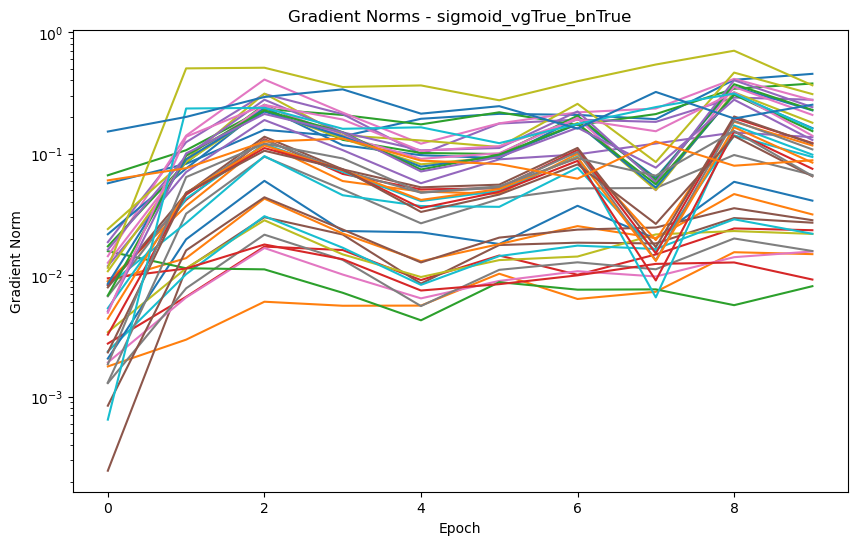

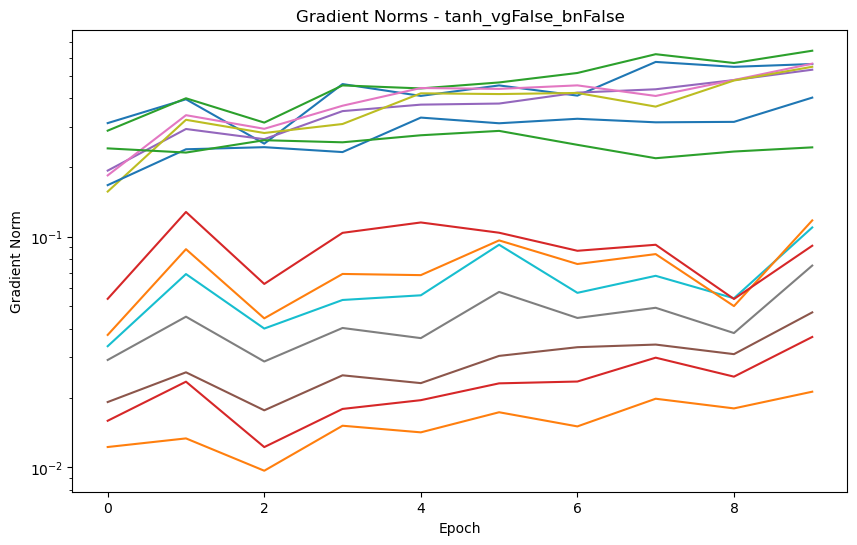

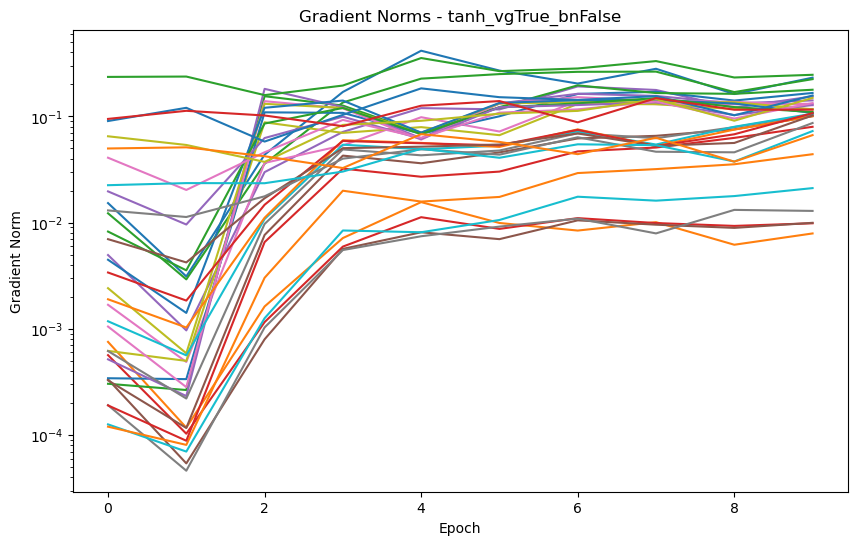

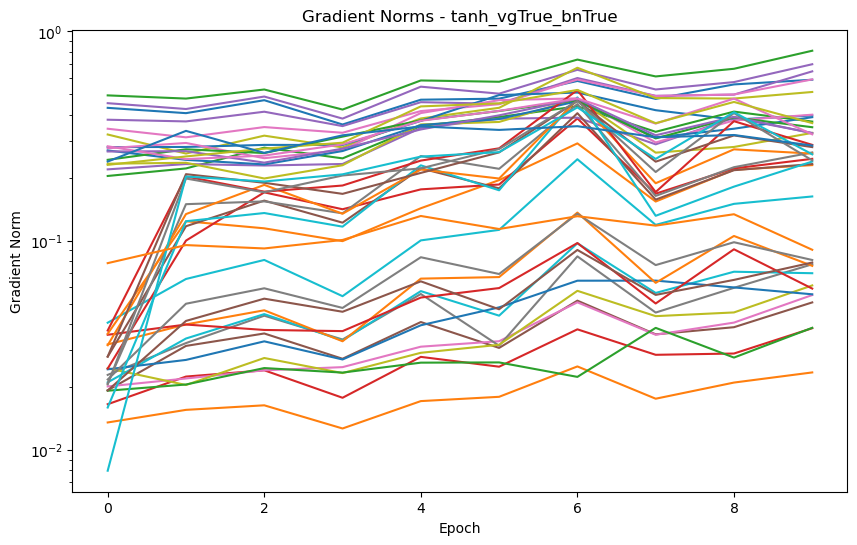

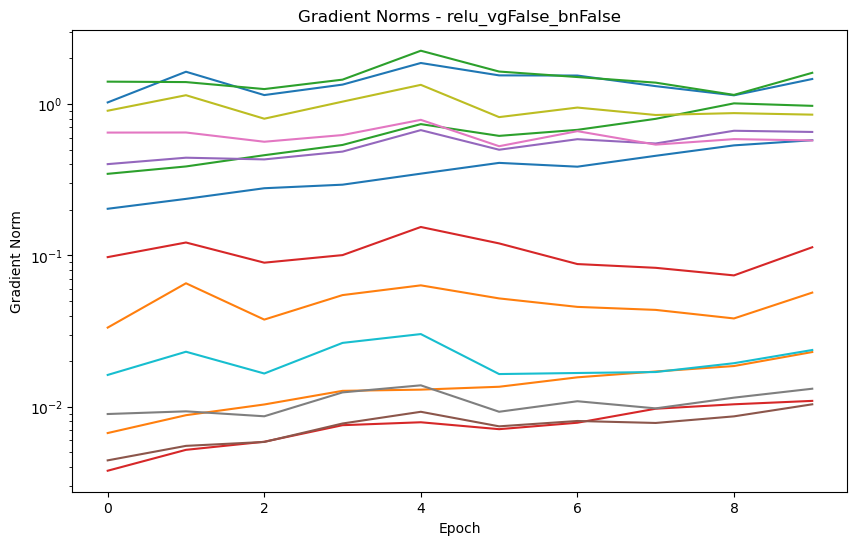

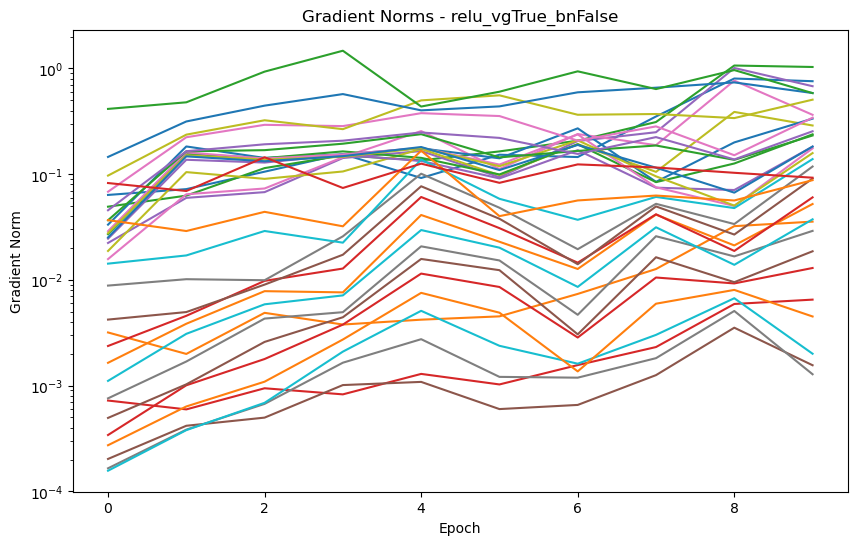

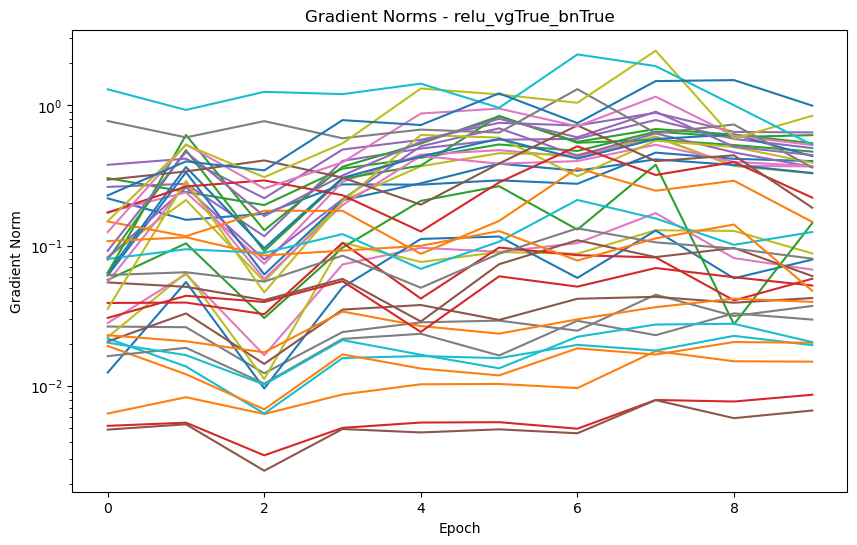

In [25]:
# Plotting gradients to show the effects of vanishing gradient and weight initialization
for name, result in results.items():
    _, _, gradient_logs = result  # Unpack the gradient logs
    plt.figure(figsize=(10, 6))
    for layer, norms in gradient_logs.items():
        plt.plot(norms, label=layer)
    plt.xlabel("Epoch")
    plt.ylabel("Gradient Norm")
    plt.yscale("log")
    plt.title(f"Gradient Norms - {name}")  # Add title with details
    # plt.legend()
    plt.show()